In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from sklearn import linear_model, feature_selection
# import sklearn

In [2]:
original = 'Data_missing_values.xlsx'
data = pd.read_excel(original)
data.describe()

,ID,sex,age,height,weight,glucose,diabetes
count,162.000000,162.000000,137.000000,140.000000,123.000000,157.000000,162.000000
mean,81.500000,0.228395,59.145985,174.342857,84.447154,92.856643,0.296296
std,46.909487,0.421100,16.677980,8.272144,16.680313,15.387021,0.458039
min,1.000000,0.000000,21.000000,150.000000,55.000000,66.071000,0.000000
25%,41.250000,0.000000,50.000000,170.000000,75.000000,79.310000,0.000000
50%,81.500000,0.000000,61.000000,175.000000,80.000000,94.077000,0.000000
75%,121.750000,0.000000,71.000000,180.000000,90.000000,105.161000,1.000000
max,162.000000,1.000000,92.000000,195.000000,160.000000,120.000000,1.000000


*1. Identifizieren sie Variablen mit fehlenden Werten und geben Sie die Häufigkeit der fehlenden Werte an.*

In [3]:
nan_uebersicht = data.isnull().sum()
print "nan_uebersicht: \n", nan_uebersicht
# Cases mit ein oder mehr NaNs & komplette Reihen in zwei dataframes zum Vergleich teilen:
fehl_daten = data[data.isnull().any(axis=1)]
komplett_daten = data[~data.isnull().any(axis=1)]
print "größe(fehlend): ", fehl_daten.shape, "\ngröße(komplett): ", komplett_daten.shape

nan_uebersicht: 
ID           0
sex          0
age         25
height      22
weight      39
glucose      5
diabetes     0
dtype: int64
größe(fehlend):  (81, 7) 
größe(komplett):  (81, 7)


Am meisten Werte fehlen bei Gewicht, gefolgt von Höhe und Alter (insgesamt 81 Reihen fallen durch Fehlen von ein oder mehr Variablen aus).

*2. Untersuchen Sie anschließend den zugrunde liegenden Mechanismus für das Auftreten der fehlenden Daten (MCAR, MAR, MNAR)*

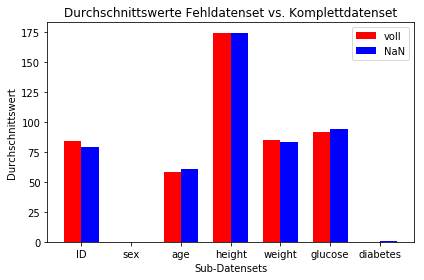

In [4]:
# Datenset ist schon 50/50 gespalten, Durchschnittswerte koennen verglichen werden:
spalten_namen = [name for name, _ in fehl_daten.iteritems()]
fehl_mean = [spalte.mean() for _, spalte in fehl_daten.iteritems()]
komplett_mean = [spalte.mean() for _, spalte in komplett_daten.iteritems()]
# Visualisierung der means:
fig, ax = plt.subplots()
index = np.arange(len(spalten_namen))
bar_breite = 0.35
komplett_daten_plot = plt.bar(index, komplett_mean, bar_breite,
                 color='r',
                 #yerr=std_komplett,
                 label='voll')
fehl_daten_plot = plt.bar(index + bar_breite, fehl_mean, bar_breite, color='b',
                 #yerr=std_fehl,
                 label='NaN')
plt.xlabel('Sub-Datensets')
plt.ylabel('Durchschnittswert')
plt.title('Durchschnittswerte Fehldatenset vs. Komplettdatenset')
plt.xticks(index + bar_breite / 2, ('ID', 'sex', 'age', 'height', 'weight', 'glucose', 'diabetes'))
plt.legend()
plt.tight_layout()
plt.show()

In [5]:
def sig_diff_check(x,y,name):
    """T-test für signifikanten unterschied zwischen zwei sample serien"""
    t_stat, p_value = stats.ttest_ind(x, y, equal_var=False)
    print "T-statistik: {}; p_value: {}".format(t_stat, p_value);
    if p_value < 0.05:
        print "Signifikanter Unterschied bei '{}' scheint mit p_value={} wahrscheinlich".format(name, p_value)
    else:
        print "Kein Signifikanter Unterschied bei {} belegbar, p_value={}".format(name, p_value)

# Überprüfen ob sich die datasets mit/ohne NaNs signifikant in einem der variablen unterscheiden
for name in ("age", "height", "weight", "glucose"):
    x = komplett_daten[name]
    y = fehl_daten[name].dropna()
    t_stat, p_value = stats.ttest_ind(x, y, equal_var=True)
    sig_diff_check(x,y,name)


T-statistik: -0.741484110846; p_value: 0.459836391091
Kein Signifikanter Unterschied bei age belegbar, p_value=0.459836391091
T-statistik: -0.0557447622351; p_value: 0.955643626171
Kein Signifikanter Unterschied bei height belegbar, p_value=0.955643626171
T-statistik: 0.765763240363; p_value: 0.445339020892
Kein Signifikanter Unterschied bei weight belegbar, p_value=0.445339020892
T-statistik: -1.11917803187; p_value: 0.264823160191
Kein Signifikanter Unterschied bei glucose belegbar, p_value=0.264823160191


Insgesamt scheint kein signifikanter Unterschied zwischen einzelnen Variablen der beiden Teil-Datasets zu geben, was eher auf MAR als MNAR hindeutet.

*Führen Sie nun folgende statistische Analysen mittels der Complete-Case Analysis Methode durch (Streichen Sie alle Patienten die mindestens eine fehlende Variable beinhalten)*


*a. Ist ein signifikanter geschlechtsspezifischer Unterschied der Körpergröße zwischen männlichen und weiblichen PatientInnen identifizierbar?*

In [8]:
def differenz_analyse(variable, datensatz):
    frauen_daten = datensatz[datensatz["sex"]==1]
    maenner_daten = datensatz[datensatz["sex"]==0]
    f = frauen_daten[variable]
    m = maenner_daten[variable]
    f_mean = f.mean()
    m_mean = m.mean()
    text_bausteine = (variable, f_mean, m_mean, (m_mean-f_mean)/f_mean*100)
    print "durchschnitt v. {} bei frauen: {} ; maenner: {}; {}% Unterschied.".format(*text_bausteine)
    sig_diff_check(f,m,variable)

differenz_analyse("height", komplett_daten)

durchschnitt v. height bei frauen: 164.764705882 ; maenner: 176.84375; 7.33108711175% Unterschied.
T-statistik: -7.73881239972; p_value: 2.7435031878e-08
Signifikanter Unterschied bei 'height' scheint mit p_value=2.7435031878e-08 wahrscheinlich


Mit sehr niedrigem p-wert können wir einen (zu erwartenden) Unterschied der Körpergröße bestätigen.

*b. Ist ein signifikanter geschlechtsspezifischer Unterschied des Blutzuckergehalts zwischen männlichen und weiblichen PatientInnen identifizierbar?*

In [9]:
differenz_analyse("glucose", komplett_daten)

durchschnitt v. glucose bei frauen: 87.5218823529 ; maenner: 92.5868125; 5.78704434925% Unterschied.
T-statistik: -1.46559079432; p_value: 0.152395395262
Kein Signifikanter Unterschied bei glucose belegbar, p_value=0.152395395262


Es scheint bei Glucose-Wert mit lediglich 5% Delta und p>0.05 *derweil* keinen signifikant belegbaren Unterschied zu geben.

*c. Berechnen Sie ein lineares Regressionsmodell, indem Sie Diabetes als abhängige Variable inkludieren und die Variablen Glucose, Gewicht, und Geschlecht als unabhängige Variablen definieren. Sehen Sie sich die Koeffizienten, sowie die P-Werte der unabhängigen Variablen an.*

In [10]:
def diabetes_regression(datensatz):
    sex = datensatz["sex"].tolist()
    weight = datensatz["weight"].tolist()
    glucose = datensatz["glucose"].tolist()
    X = [[sex[i],weight[i],glucose[i]] for i in range(len(sex))]
    y = datensatz["diabetes"].tolist()
    regressor = linear_model.LinearRegression()
    regressor.fit(X,y)
    print "multivariate ergebnisse:"
    print "r^2:", regressor.score(X,y)
    print "intercept:", regressor.intercept_
    print "koeffizienten:", regressor.coef_
    _, p_val_coef =  feature_selection.chi2(X,y)
    print "p-wert der variablen - geschlecht: {}, gewicht: {}, blutzucker: {}\n".format(*p_val_coef)

    
# multi-regression:
diabetes_regression(komplett_daten)

# da glucose viel stärker mit target korreliert, probiere univariate regression als cross-check
def univariate_glucose(datensatz):
    print "univariate glucose ergebnisse"
    einzel_X = datensatz["glucose"].tolist()
    y = datensatz["diabetes"].tolist()
    slope, inter, r_value, p_value, std_err = stats.linregress(einzel_X,y)
    print "slope", slope, "\ninter", inter, "\nr^2", r_value*r_value,"\np", p_value, "\nstd", std_err
univariate_glucose(komplett_daten)

multivariate ergebnisse:
r^2: 0.185273559182
intercept: -0.725130908565
koeffizienten: [-0.06631099 -0.00021921  0.00989758]
p-wert der variablen - geschlecht: 0.29986191089, gewicht: 0.612939235189, blutzucker: 3.36982918093e-09

univariate glucose ergebnisse
slope 0.0101794718195 
inter -0.783515819896 
r^2 0.18009005193 
p 7.87120823577e-05 
std 0.00244371140105


Blutzucker ist wie erwartet stark signifikant für Diabetes-Vorhersage; Gewicht aber hier anscheinend nicht, was überraschend ist (nach Allgemeinwissen sollte Übergewicht nämlich mit Diabetes stark korrelieren). Eventuell eine Frage der Missing Data Imputation (siehe unten - Signifikanz wird verstärkt).

Insgesamt relativ geringe r^2 scores.

*Führen Sie nun eine Mean-Imputation der fehlenden Werte durch. Führen Sie nun die oben angegebenen statistischen Analysen mit den imputierten Daten durch. Welche Unterschiede können Sie bemerken?*

In [11]:
means = data.mean()
# "mean sex" ist zwar 0.21 (nonsense) 
# aber ist bei imputation kein Problem da bei geschlecht & ID keine Angaben fehlen
imputierte_daten = data.fillna(data.mean())

differenz_analyse("height", imputierte_daten)
differenz_analyse("glucose", imputierte_daten)
diabetes_regression(imputierte_daten)

durchschnitt v. height bei frauen: 165.776061776 ; maenner: 176.878628571; 6.69732811627% Unterschied.
T-statistik: -8.99614887043; p_value: 2.85591754242e-12
Signifikanter Unterschied bei 'height' scheint mit p_value=2.85591754242e-12 wahrscheinlich
durchschnitt v. glucose bei frauen: 88.0065212601 ; maenner: 94.2922794395; 7.14237773448% Unterschied.
T-statistik: -2.63402837541; p_value: 0.0101593917409
Signifikanter Unterschied bei 'glucose' scheint mit p_value=0.0101593917409 wahrscheinlich
multivariate ergebnisse:
r^2: 0.227437030771
intercept: -1.06172636004
koeffizienten: [ 0.09105878 -0.00024399  0.01462286]
p-wert der variablen - geschlecht: 0.989360908712, gewicht: 0.285034393871, blutzucker: 8.00161071084e-21



P-Wert für Gewicht ist gesunken (aber noch nicht unter der arbiträren standard-5% Schwelle); P-Wert für Geschlecht hat sich erhöht (mehr Daten).
Geschlechtsunterschied bei Glukose wurde als signifikant erhöht. Das lineare Regressionsmodell hat einen etwas höheren R^2 Score erreicht, da mehr Daten inkludiert werden können.